In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def lasso_model_train(data_train, data_test, target_feature, input_features):
    
    df_train = data_train[input_features + [target_feature]].copy()
    df_train.dropna(inplace=True)
    
    df_test = data_test[input_features + [target_feature]].copy()
    df_test.dropna(inplace=True)

    # Take the whole training set as training data
    X_train = df_train.drop(target_feature, axis=1)
    Y_train = df_train[target_feature]

    # Take only 60% of the test set as training data
    X_test = df_test.drop(target_feature, axis=1)
    Y_test = df_test[target_feature]

    # Identify which columns get which treatment
    binary_features = ['alc_any']
    categorical_features = ['gender', 'race']
    numerical_features = ['exerc', 'age', 'fincur', 'gpa_sr']
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop=[2,7])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features),
            ('bin', 'passthrough', binary_features)
        ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LassoCV(cv=5, random_state=781, n_alphas=100)) 
    ])

    pipeline.fit(X_train, Y_train)
    print("\n--- Results for {} ---".format(target_feature))
    # Evaluate MSE on train and test sets
    train_preds = pipeline.predict(X_train)
    test_preds = pipeline.predict(X_test)

    mse_train = np.mean((Y_train - train_preds) ** 2)
    mse_test = np.mean((Y_test - test_preds) ** 2)

    print(f"Train MSE: {mse_train:.4f}")
    print(f"Test MSE:  {mse_test:.4f}")

    # Get the best alpha found during the cross-validation
    best_alpha = pipeline.named_steps['model'].alpha_
    print(f"Optimal alpha found by CV: {best_alpha:.4f}")

    # Get the R-squared score on the test data
    test_r2 = pipeline.score(X_test, Y_test)
    print(f"Test Set R-squared (R2): {test_r2:.4f}")

    # You can also see the coefficients of this final model
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    coefficients = pd.Series(pipeline.named_steps['model'].coef_, index=feature_names)

    print("\nCoefficients of the LASSO model for {}:".format(target_feature))
    print(coefficients)

    return pipeline, X_test, Y_test

In [3]:
def confusion_matrix_generate(pipeline, X_test, Y_test, display_labels, target_feature, compare_up):

    prediction = pipeline.predict(X_test)
    threshold = np.median(Y_test)

    if compare_up:
        preds_unhappy = (prediction > threshold).astype(int)
        y_val_unhappy = (Y_test > threshold).astype(int)
    else:
        preds_unhappy = (prediction < threshold).astype(int)
        y_val_unhappy = (Y_test < threshold).astype(int)

    cm = confusion_matrix(y_val_unhappy, preds_unhappy)

    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Create a display object
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    # Plot the matrix
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for {}".format(target_feature))
    plt.show()

    print('accuracy = ', str(accuracy*100))
    print('precision = ', str(precision*100))
    print('recall = ', str(recall*100))
    print('f1 = ', str(f1*100))

In [ ]:
path = '../../data/processed'

train_path_1 = os.path.join(path, 'all_data_train.csv')
train_data_1 = pd.read_csv(train_path_1, low_memory=False)
train_path_2 = os.path.join(path, 'all_data_additional_train.csv')
train_data_2 = pd.read_csv(train_path_2, low_memory=False)
train_data = pd.concat([train_data_1, train_data_2])

test_path = os.path.join(path, 'all_data_validation.csv')
test_data = pd.read_csv(test_path, low_memory=False)

In [5]:
input_features = ['fincur', 'exerc', 'gender', 'race', 'age', 'gpa_sr', 'alc_any']

fl_pipe, fl_X_test, fl_Y_test = lasso_model_train(train_data, test_data, 'flourish', input_features)
ax_pipe, ax_X_test, ax_Y_test = lasso_model_train(train_data, test_data, 'anx_score', input_features)
dp_pipe, dp_X_test, dp_Y_test = lasso_model_train(train_data, test_data, 'deprawsc', input_features)


--- Results for flourish ---
Train MSE: 70.2245
Test MSE:  70.1700
Optimal alpha found by CV: 0.0018
Test Set R-squared (R2): 0.0916

Coefficients of the LASSO model for flourish:
num__exerc       1.224368
num__age         0.717078
num__fincur      1.735836
num__gpa_sr     -0.724253
cat__gender_1    1.071400
cat__gender_3   -3.979119
cat__gender_4   -4.041552
cat__race_1      1.501099
cat__race_2      0.000000
cat__race_3     -1.355485
cat__race_4      0.089247
cat__race_5      0.308824
cat__race_6     -0.059435
bin__alc_any     0.127820
dtype: float64

--- Results for anx_score ---
Train MSE: 28.0644
Test MSE:  27.7222
Optimal alpha found by CV: 0.0018
Test Set R-squared (R2): 0.1572

Coefficients of the LASSO model for anx_score:
num__exerc      -0.492343
num__age        -0.620068
num__fincur     -1.743058
num__gpa_sr      0.148623
cat__gender_1    1.630487
cat__gender_3    3.047478
cat__gender_4    3.865348
cat__race_1     -1.432389
cat__race_2      0.000000
cat__race_3     -0.5471

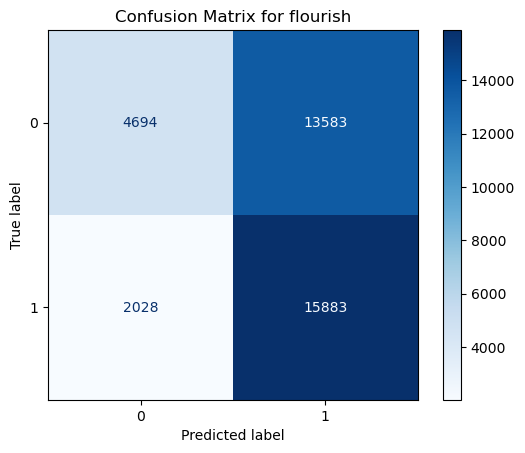

accuracy =  56.86139051619321
precision =  53.90280323084232
recall =  88.67734911506895
f1 =  67.04941216201954


In [6]:
confusion_matrix_generate(fl_pipe, fl_X_test, fl_Y_test, ['0', '1'], "flourish", compare_up=False)

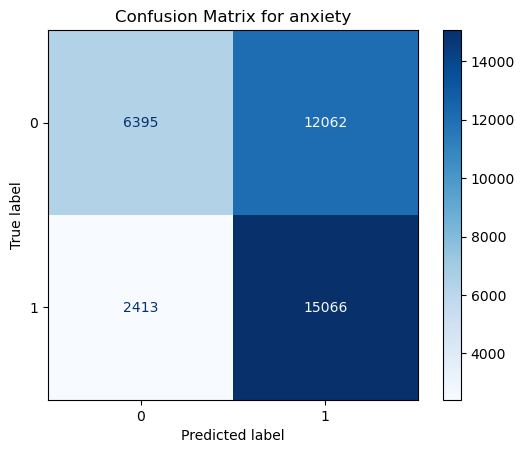

accuracy =  59.720057880676755
precision =  55.53671483338248
recall =  86.19486240631615
f1 =  67.5499361086825


In [7]:
confusion_matrix_generate(ax_pipe, ax_X_test, ax_Y_test, ['0', '1'], "anxiety", compare_up=True)

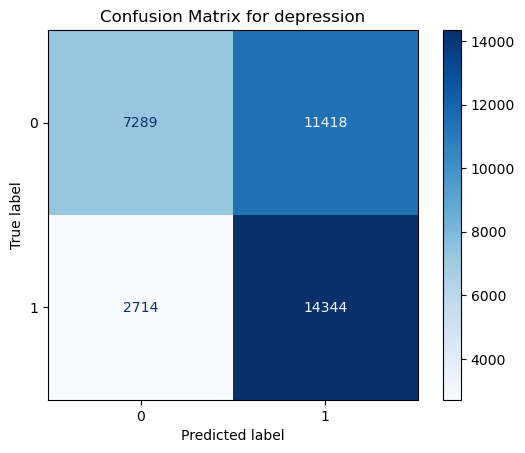

accuracy =  60.48650915699706
precision =  55.67890691716482
recall =  84.08957673818736
f1 =  66.99673049976647


In [9]:
confusion_matrix_generate(dp_pipe, dp_X_test, dp_Y_test, ['0', '1'], "depression", compare_up=True)